In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [2]:
data2 = [[1, 2, 3, 4], [5, 6, 7,9]]
np.array(data2).dtype

dtype('int32')

In [3]:
zero = np.zeros((2,4,3), dtype=np.int8)
zero

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=int8)

In [4]:
zero = np.zeros((2,4,3), dtype=np.int8)
a = zero[:,-1,0].copy()
a += 9
zero

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=int8)

In [5]:
arr2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr2d

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [6]:
arr2d[:,1]

array([2, 5, 8])

In [7]:
arr3d = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
arr3d

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [8]:
peppa = np.empty_like(arr3d).astype(np.float64)
np.sqrt(arr3d, out=peppa)
peppa

array([[[1.        , 1.41421356, 1.73205081],
        [2.        , 2.23606798, 2.44948974]],

       [[2.64575131, 2.82842712, 3.        ],
        [3.16227766, 3.31662479, 3.46410162]]])

In [9]:
np.arange(-5, 5.1, 0.1)[-1]

4.9999999999999645

In [10]:
np.linspace(-5, 5, 100)[-1]

5.0

In [11]:
r = arr3d[:,:,::2]
r += 100
arr3d

array([[[101,   2, 103],
        [104,   5, 106]],

       [[107,   8, 109],
        [110,  11, 112]]])

In [12]:
rng = np.random.RandomState(seed=2)

rng.randint(10,20, 8)

array([18, 18, 16, 12, 18, 17, 12, 11])

In [13]:
points = np.arange(-5, 5, 0.01)
xs, ys = np.meshgrid(points, points)

In [14]:
points.shape

(1000,)

In [15]:
xs

array([[-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99],
       [-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99],
       [-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99],
       ...,
       [-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99],
       [-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99],
       [-5.  , -4.99, -4.98, ...,  4.97,  4.98,  4.99]])

In [16]:
ys

array([[-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
       [-4.99, -4.99, -4.99, ..., -4.99, -4.99, -4.99],
       [-4.98, -4.98, -4.98, ..., -4.98, -4.98, -4.98],
       ...,
       [ 4.97,  4.97,  4.97, ...,  4.97,  4.97,  4.97],
       [ 4.98,  4.98,  4.98, ...,  4.98,  4.98,  4.98],
       [ 4.99,  4.99,  4.99, ...,  4.99,  4.99,  4.99]])

In [17]:
z = np.sqrt(xs ** 2 + ys ** 2)

Text(0.5, 1.0, 'Image plot of $\\sqrt{x^2 + y^2}$ for a grid of values')

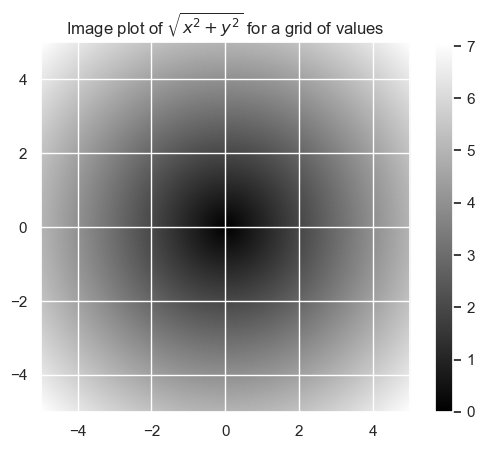

In [18]:
plt.imshow(z, cmap=plt.cm.gray, extent=[-5, 5, -5, 5])
plt.colorbar()
plt.title("Image plot of $\sqrt{x^2 + y^2}$ for a grid of values")

In [19]:
plt.close("all")

In [20]:
rng = np.random.default_rng(1)

arr = rng.random(size=(4, 3, 2))
arr

array([[[0.51182162, 0.9504637 ],
        [0.14415961, 0.94864945],
        [0.31183145, 0.42332645]],

       [[0.82770259, 0.40919914],
        [0.54959369, 0.02755911],
        [0.75351311, 0.53814331]],

       [[0.32973172, 0.7884287 ],
        [0.30319483, 0.45349789],
        [0.1340417 , 0.40311299]],

       [[0.20345524, 0.26231334],
        [0.75036467, 0.28040876],
        [0.48519097, 0.9807372 ]]])

In [26]:
arr[1,0,:]

array([0.82770259, 0.40919914])

In [30]:
np.unique(arr.argmin(axis=2))

array([0, 1], dtype=int64)

In [28]:
np.where(arr<0.6, 1, arr).shape == arr.shape

True

In [31]:
array = np.linspace(0,37,36)
np.save('peppa_pig', array)

In [32]:
np.load('peppa_pig.npy')

array([ 0.        ,  1.05714286,  2.11428571,  3.17142857,  4.22857143,
        5.28571429,  6.34285714,  7.4       ,  8.45714286,  9.51428571,
       10.57142857, 11.62857143, 12.68571429, 13.74285714, 14.8       ,
       15.85714286, 16.91428571, 17.97142857, 19.02857143, 20.08571429,
       21.14285714, 22.2       , 23.25714286, 24.31428571, 25.37142857,
       26.42857143, 27.48571429, 28.54285714, 29.6       , 30.65714286,
       31.71428571, 32.77142857, 33.82857143, 34.88571429, 35.94285714,
       37.        ])

In [47]:
import random
position = 0
walk = [position]
nsteps = 1000
for _ in range(nsteps):
    step = 1 if random.randint(0, 1) else -1
    position += step
    walk.append(position)

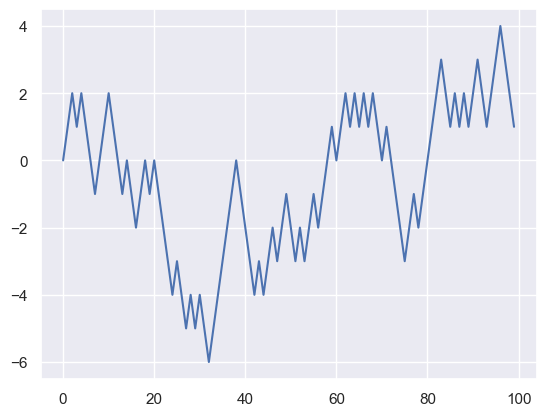

In [48]:
plt.plot(walk[:100]);

In [89]:
np.random.randint(2, size=(2,5)).sum(axis=0)

array([1, 0, 2, 1, 1])

In [90]:
rw = np.random.randint(2, size=(5000,1000))

In [91]:
steps = np.where(rw<1, -1, 1)

In [92]:
destination = steps.sum(axis=1)
destination.shape

(5000,)

In [93]:
destination.max()

110

In [94]:
destination.min()

-108

In [97]:
position = steps.cumsum(axis=1)

In [98]:
position.min()

-116

In [99]:
position.max()

113

In [104]:
hits50 = (np.abs(position) == 50).any(axis=1)
hits50.sum()

1134

In [102]:
destination.mean()

0.504

In [116]:
first_50 = (np.abs(position[hits50]) == 50)

In [124]:
first_50.argmax(axis=1).mean()

667.6137566137567

In [113]:
first_50

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [110]:
first_50.mean()

0.0